# SLU11: Model Validation
---

## 1 About the data

We will be using data about craft beer to try to predict whether a particular beer is an Indian Pale Ale (IPA), based on its bitterness and color. From the [Wikipedia](https://en.wikipedia.org/wiki/India_pale_ale):

> India Pale Ale (IPA) is a hoppy beer style within the broader category of pale ale. (...) The term *pale ale* originally denoted an ale that had been brewed from pale malt.

The data was preprocessed in advance, as the original dataset was simplified and manipulated for teaching purposes. There are two features:
* `IBU`, which stands for International Bitterness Units and is a measure of bitterness
* `Color`.

The response variable `IsIPA` is binary and indicates whether or not a given observation is an IPA.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/beer.csv')
data.head(n=3)

,IBU,Color,IsIPA
0,-0.970233,-0.652164,0
1,1.387356,-0.377297,1
2,0.442296,0.183752,0


In [2]:
X = data.copy()
y = X.pop('IsIPA')

---

## 2 Overfitting
<a id="overfitting"></a>

One way to understand overfitting is by decomposing the generalization error of a model into bias and variance.

### 2.1 Bias-variance trade-off

#### 2.1.1 Generalization error

In machine learning, unlike most other optimization problems, we don't know the function we want to optimize.

Our goal is to estimate the target function *f* that maps input data X to the output variable *y*, given our hypothesis and some parameters (i.e., the knobs):

$$ \hat{y} = h_\Theta(X) $$

To do so, we minimize how wrong the model is by comparing estimated predictions against real values:

$$min \space J(\Theta) = - \frac{1}{m} \sum\limits_{i=1}^m \mathcal{L}(\hat{y}^{(i)}, y^{(i)})$$

The bias-variance decomposition is a way of analyzing an algorithm's expected generalization error, with respect to the sum of three terms:

1. Bias
2. Variance
3. Irreducible error.

As we will see, dealing with bias and variance is really about under- (high bias) and over-fitting (high variance).

#### 2.1.3 Error due to bias and *underfitting*

Bias typically results from oversimplifying assumptions, skewing results consistently across all realizations of the model and lacking the flexibility to fit underlying patterns. 

It measures how far off these predictions are from the actual value by taking the difference between the expected prediction and the correct value:

$$ Bias = (E[\hat{y}] - y)^2 $$

Bias is the tendency to learn the same wrong thing, and represents *underfitting* (i.e., missing parameters that would appear in a correctly specified model).

Fixing bias requires adding complexity to our models.

#### 2.1.4 Error due to variance and *overfitting*

Highly flexible and data-adaptive approaches, on the other side, may lead the model to overreact to the specifics of the training data and, thus, to high variance.

Along the same lines, the variance is how much the predictions for a given point vary betweeen the different realizations of the model:

$$ Variance = E[(\hat{y} - y)^2] $$

Variance is the tendency to learn random things, and is a sign of *overfitting* (i.e., including more parameters than can be justified by the data).

Fixing variance requires decreasing model complexity.

#### 2.1.5 The trade-off

![dart_throwing_bias_var_tradeoff](assets/dart_throwing_bias_var_tradeoff.png)

*Fig. 1: Graphical illustration of the bias-variance trade-off, borrowed from [Scott Fortmann-Row's "Understanding the Bias-Variance Trade-off](http://scott.fortmann-roe.com/docs/BiasVariance.html)*

The need for generalization has a major consequence: data alone is not enough, regardless of how much of it we have. 

In the real world of imperfect models and limited data, there is an explicit trade-off: 

> Bias is reduced and variance is increased in relation to model complexity (e.g., additional features, increasing polynomial, using highly flexible models)

![bias_variance_tradeoff_complexity](assets/right_fited_model.png)

*Fig. 2: How bias and variance relate to model complexity, an adaptation from Scott Fortman-Row's article [found here](http://www.ebc.cat/2017/02/12/bias-and-variance/)*

In theory, we reach the right level of complexity when the increase in bias is equivalent to the reduction in variance:

$$ \frac{dBias}{dComplexity} = - \frac{dVariance}{dComplexity} $$

In practice, *there is not an analytical way to find this location*. Below are three different models that perform differently in terms of bias and variance.

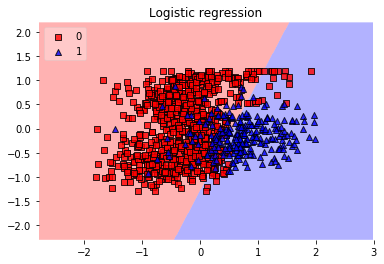

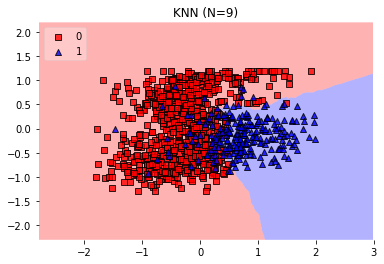

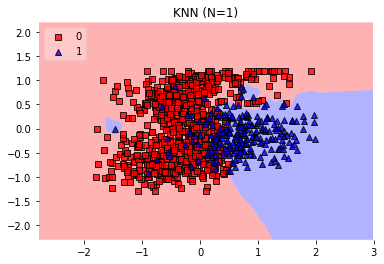

In [3]:
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline


clfs = {'Logistic regression': LogisticRegression(),
        'KNN (N=9)': KNeighborsClassifier(n_neighbors=9),
        'KNN (N=1)': KNeighborsClassifier(n_neighbors=1)}
   
for key, clf in clfs.items():
    plt.figure()
    plt.title(key)
    plot_decision_regions(X.values, y.values, clf=clf.fit(X, y), legend=2)

---

## 3 Evaluating model performance

### 3.1 In-sample-error (ISE) or training error


The in-sample-error is how well our model performs on the training data, regardless of generalization.

In [4]:
from sklearn.metrics import accuracy_score

def classification_error(clf, X, y):
    y_pred = clf.predict(X)
    error_rate = 1 - accuracy_score(y, y_pred)
    return round(error_rate * 100, 2)
                 
for key, clf in clfs.items():
    clf.fit(X, y)
    training_error = classification_error(clf, X, y)
    print('{} error:\nTrain: {}%'.format(key, training_error))

Logistic regression error:
Train: 12.0%
KNN (N=9) error:
Train: 6.8%
KNN (N=1) error:
Train: 0.0%


This alone is wrong because we want our models to learn, rather than memorize (e.g., like a lookup table). Remember: the purpose of a model is to generalize to unseen data.

Testing our model on the training data is a common mistake and, although it can be a useful metric, it tells part of the story.

### 3.2 Out-of-sample error (OSE) or testing error

The out-of-sample error is, precisely, how well the model previsouly on new data. It's the second part of the story.

What we want to understand here is if the model iis picking up patterns that generalize.

![different_validation_methods](assets/different_validation_techniques.png)

*Fig. 3:* Different validation techniques, as illustrated by [Towards Data Science's "Train/Test Split and Cross Validation in Python"](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)

#### 3.1.1 Train-test split (aka holdout method)

The most common way of measuring the OSE is setting some of the data aside from the beginning and only use it to test your classifier at the end, when modeling is complete.

![test_set](assets/test_set.png)

*Fig 4: Test set illustrated*

Please, keep your test data aside for the entire modelling process, otherwise you're using it to train your model.

If you are confident about your final classifier after evaluation, you should relearn it on the whole data.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print("Number of observations:\nTrain: {} | Test: {}".format(X_train.shape[0], X_test.shape[0]))

Number of observations:
Train: 600 | Test: 400


In [6]:
def compute_metrics(X_train, y_train, X_test, y_test, clf):
    training_error = classification_error(clf, X_train, y_train)
    test_error = classification_error(clf, X_test, y_test)
    return training_error, test_error

for key, clf in clfs.items():
    clf.fit(X_train, y_train)
    training_error, test_error = compute_metrics(X_train, y_train, X_test, y_test, clf)
    print('{} error:\nTrain: {:5}% | Test: {}%'.format(key, training_error, test_error))

Logistic regression error:
Train:  11.5% | Test: 12.25%
KNN (N=9) error:
Train:   7.0% | Test: 9.25%
KNN (N=1) error:
Train:   0.0% | Test: 11.25%


Ideally, both training and test errors are low and close to one another. The model has anough flexibility to pick up the signal (some of it, at least) and not the noise.

Of course, holding out data reduces the amount available for training. Also, for small datasets, the results can be subject to great variability, depending on how you split the data.

**Overfitting**

Overfitting is detected when a model that performs on training data but not quite so well in the test set: the bigger the gap, the greater the overfitting.

**Underfitting**

On the other side, underfitted models tend to perform poorly on both train and test data, having large (and similar) in-sample- and out-of-sample errors.

#### 3.1.2 Validation set

If you need to keep the test data aside until we have a final model, how can we diagnose under- and overfitting? Given we have enough data, we create a validation dataset.

![validation_set](assets/validation_set.png)

*Fig. 5: Validation set as compared with the holdout approach*

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)
del X_temp, y_temp

print("Number of observations:\nTrain: {} | Test: {} | Validation: {}".format(X_train.shape[0], X_test.shape[0], X_val.shape[0]))

Number of observations:
Train: 600 | Test: 200 | Validation: 200


In [8]:
def compute_validation_metrics(X_train, y_train, X_test, y_test, X_validation, y_validation, clf):
    training_error, test_error = compute_metrics(X_train, y_train, X_test, y_test, clf)
    validation_error = classification_error(clf, X_validation, y_validation)
    return training_error, test_error, validation_error

for key, clf in clfs.items():
    clf.fit(X_train, y_train)
    training_error, test_error, validation_error = compute_validation_metrics(X_train, y_train, X_test, y_test, X_val, y_val, clf)
    print('---\n{} error:\nTrain: {:5}% | Test: {:4}% | Validation: {:4}%'.format(key, training_error, test_error, validation_error))

---
Logistic regression error:
Train: 10.67% | Test: 16.5% | Validation: 10.0%
---
KNN (N=9) error:
Train:   9.0% | Test:  8.5% | Validation:  3.5%
---
KNN (N=1) error:
Train:   0.0% | Test: 15.0% | Validation:  9.5%


#### 3.1.3 *K*-fold cross validation

In *k*-fold cross validation (where *K* represents the number of train/validation splits) the original sample is randomly partitioned into *k* equal sized subsamples.

![cross_validation](assets/cross_validation.png)

This method is most suited for small to medium size datasets.

In [9]:
from sklearn.model_selection import cross_val_score


for key, clf in clfs.items():
    scores = cross_val_score(clf, X, y, cv=5, scoring=classification_error)
    mean_error = round(np.mean(scores), 2)
    var_error = round(np.var(scores), 2)
    print('---\n{} validation error:\nMean: {:5}% | Variance: {:4}'.format(key, mean_error, var_error))

---
Logistic regression validation error:
Mean:  12.1% | Variance: 3.28
---
KNN (N=9) validation error:
Mean:  7.89% | Variance: 4.18
---
KNN (N=1) validation error:
Mean: 11.49% | Variance: 8.29
